In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from itertools import repeat
df = pd.read_csv("CombinedSequences_ppr.csv")

In [2]:
seq = df['Sequence'].to_numpy()

def kmerise(line,k):  # String and k are inputs
    kmerised_array = []; # Final kmerised list
    for i in line:
        temp = []
        for j in range(0,len(i),k): 
            temp.append(i[j:j+k]) #append substring in each iter 
        kmerised_array.append(temp)
    
    return kmerised_array

In [3]:
df['AccessionID'] = pd.factorize(df['AccessionID'])[0]
df.head()

,AccessionID,Sequence
0,0,ATGAGAGTTCAAAGACCACCCACTCTCTTGTTAGTGTTCTCACTCT...
1,0,ATGATACACTCAGTGTTTCTACTGATGTTCTTGTTAACACCTACAG...
2,0,TATGCCTAACATGTGTAGGATTTTCGCGTCTCTGATTTTGGCACGC...
3,0,TATGCCTAACATGTGTAGGATTTTTGCATCTCTGATTTTGGCACGC...
4,0,TATGCCTAACATGTGTAGGATTTTCGCGTCTCTGATTTTGGCACGC...


In [4]:
df.tail()

,AccessionID,Sequence
2519,2,GACTAAAGATAAAAATTATATACGTATAATTTTTGTCTCTCTAGCT...
2520,2,GACAAAGGTGAAAATTAATATATATATATTAATTTTACTCCTCCTC...
2521,2,GTCATTTGGTAAAATATAATATATATTTTATCACTCTAGCTTCGCT...
2522,2,GACAAAGCTCAAAAATATATATATATATTTTTGTTGCTCCTAGCTT...
2523,2,GACTAAAGATAAAAATTATAGCATTAGTCTATAATTTTATCTCCCT...


In [5]:
k = 15
kmers_list =  kmerise(seq,k)

In [6]:
baseDict = {'A': 1, 'C': 2, 'G': 3, 'T': 4, 'R': 5, 'Y': 6, 'S': 7, 'W': 8, 'K': 9, 'M': 10, 'B': 11, 'D': 12, 'H': 13, 'V': 14,'N': 15}

In [7]:
def vectorizedList(line):  # String and k are inputs
    vectorized_array = []; # Final vectorised list
    for i in line:
        temp = ""
        for j in range(len(i)):
            temp += str(baseDict[i[j]])
        vectorized_array.append(int(temp))
    
    return vectorized_array

In [8]:
Vec = []
len_vec = []
for i in range(len(kmers_list)):
    Vec.append(vectorizedList(kmers_list[i]))
    len_vec.append(len(kmers_list[i]))
#Vec

In [9]:
f = [[float(i) for i in j] for j in Vec]
Vec = [[i / sum(j) for i in j] for j in f]

In [10]:
def padding(seq, len_vec):
    anotherseq = seq.copy()
    max_kmerlen = max(len_vec)
    for i in anotherseq:
        diff = max_kmerlen - len(i)
        i.extend(repeat(0, diff))
    
    return anotherseq    

In [11]:
pad = padding(Vec, len_vec)

In [12]:
import keras
from keras.layers import Conv2D, MaxPooling2D,GRU, Dense, Embedding
from keras.layers import Input, Dropout, Activation
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [13]:
X = np.asarray(pad)#.astype(np.float32)
y = df['AccessionID'].to_numpy()#.astype(np.float32)

In [14]:
X.shape

(2524, 2118)

In [15]:
data_shape = [353,6]
X = X.reshape(2524,data_shape[0],data_shape[1])
x_train, x_test, y_train, Y_test = train_test_split(X, y, test_size=0.33)

In [16]:
x_train = x_train.astype('float32') 
x_test = x_test.astype('float32') 

In [17]:
fields = len(np.unique(df['AccessionID']))
#For training data
y_train = np.uint8(keras.utils.to_categorical(y_train, num_classes = fields))

#For test data
y_test = np.uint8(keras.utils.to_categorical(Y_test, num_classes = fields))

In [18]:
print(x_train.shape)
print(x_test.shape)

(1691, 353, 6)
(833, 353, 6)


In [19]:
print(y_train.shape)
print(y_test.shape)

(1691, 3)
(833, 3)


In [20]:
from keras.utils.np_utils import to_categorical
from keras.models import Model ,Sequential
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold

In [21]:
# Input for variable-length sequences of integers
model = Sequential()
model.add(GRU(256,activation = 'relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
# Add a classifier
model.add(Dense(3, activation="softmax"))

In [22]:
model.compile(optimizer='adagrad', loss = "categorical_crossentropy", metrics = ['accuracy']) 

In [23]:
history = model.fit(x_train, y_train, epochs = 16)
model.summary()

Epoch 1/16
53/53 [==============================] - 24s 361ms/step - loss: 1.0902 - accuracy: 0.6326
Epoch 2/16
53/53 [==============================] - 22s 421ms/step - loss: 1.0549 - accuracy: 0.6679
Epoch 3/16
53/53 [==============================] - 24s 451ms/step - loss: 1.0271 - accuracy: 0.6803
Epoch 4/16
53/53 [==============================] - 24s 445ms/step - loss: 1.0065 - accuracy: 0.6649
Epoch 5/16
53/53 [==============================] - 25s 463ms/step - loss: 0.9872 - accuracy: 0.6563
Epoch 6/16
53/53 [==============================] - 24s 459ms/step - loss: 0.9660 - accuracy: 0.6668
Epoch 7/16
53/53 [==============================] - 23s 440ms/step - loss: 0.9505 - accuracy: 0.6549
Epoch 8/16
53/53 [==============================] - 23s 431ms/step - loss: 0.9324 - accuracy: 0.6514
Epoch 9/16
53/53 [==============================] - 23s 436ms/step - loss: 0.9094 - accuracy: 0.6626
Epoch 10/16
53/53 [==============================] - 23s 438ms/step - loss: 0.8935 - accura

In [24]:
#Printing the loss and accuracy of training and testing sets
loss, accuracy = model.evaluate(x_train, y_train, verbose=1)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("\nFinal Loss = ",loss)

53/53 [==============================] - 6s 108ms/step - loss: 0.7928 - accuracy: 0.6629
Training Accuracy: 0.6629
27/27 [==============================] - 3s 102ms/step - loss: 0.7759 - accuracy: 0.6843
Testing Accuracy:  0.6843

Final Loss =  0.7759156227111816


In [25]:
y_pred = model.predict(x_test)
Y_pred_classes = np.argmax(y_pred,axis=1)
y_act = np.argmax(y_test,axis=1)

In [26]:
conf_matrix = np.zeros((3,3))
for i in range(len(y_act)):
    conf_matrix[Y_pred_classes[i]][y_act[i]] += 1
conf_matrix

array([[  0.,   0.,   0.],
       [256., 570.,   7.],
       [  0.,   0.,   0.]])

In [31]:
precision = precision_score(Y_test, Y_pred_classes, average='macro')
recall = recall_score(Y_test, Y_pred_classes, average='macro')
f1score = f1_score(Y_test, Y_pred_classes, average='macro')
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1score)

Precision:  0.22809123649459784
Recall:  0.3333333333333333
F1-score:  0.27084818246614395


C:\Users\ARRUN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
#roc auc score
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import roc_curve, auc
roc_auc_score(y_test, y_pred, multi_class='ovo', average='weighted')

0.49973368896952197

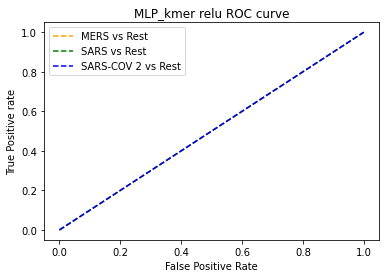

In [29]:
import matplotlib.pyplot as plt
# roc curve for classes
fpr = {}
tpr = {}
roc_auc ={}

for i in range(fields):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='MERS vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='SARS vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='SARS-COV 2 vs Rest')
plt.title('MLP_kmer relu ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

In [30]:
print(roc_auc)

{0: 0.49913344887348354, 1: 0.5, 2: 0.5, 'micro': 0.8378429402973675}
